# Paraphrase Model Development
### In this notebook, we will explore how to build models for paraphrasing sentences using both simple and advanced approaches. 
### With the aim to answer the question : How do you evaluate whether your model is good at paraphrasing?
# 1. Problem Understanding & Assumptions

## Dataset Overview
 - We are working with the Quora Question Pairs dataset
 - The data contains pairs of questions where some are paraphrases of each other
 - We will use this for training and evaluating paraphrase generation models
 
## Key Assumptions
 - Paraphrases should maintain the same semantic meaning as the original sentence
 - A good paraphrase should be different in structure/wording from the original
 - Different approaches may have different strengths (diversity vs. meaning preservation)
 - Automatic evaluation metrics provide useful but imperfect signals of quality
 
## Evaluation Approach
 - We will use both automatic metrics (BLEU, ROUGE, BERTScore), semantic similarity, lexical diversity and fluency measures.
 - Develop a reward/evaluator model for specialized evaluation on this dataset.

## Planned Methodology
- Implement and fine-tune a statistical baseline method using word net synonym search and replacement. 
- Fine-tune for paraphrasing a more complex model, SmolLM-135M via SFT and LoRA.
- Compare and analyze results from both methods 

## Imports, constants and global variables

In [22]:

import pandas as pd
from datasets import load_dataset, DatasetDict, ClassLabel
from torch.utils.data import Dataset, DataLoader
from dataset.quora_dataset import QuoraDataset
from tqdm import tqdm
from utils import *
from matplotlib import pyplot as plt
import seaborn as sns
from nltk.stem import WordNetLemmatizer
import nltk
from models.word_net_paraphraser import WordNetParaphraser
from paraphrase_evaluator import ParaphraseEvaluator
from models.reward_model import RewardModel
from trainers.reward_trainer import train_reward_model
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead

import sentence_transformers
import torch.nn.functional as F

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('punkt_tab')
tqdm.pandas()

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/ericsaikali/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ericsaikali/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### Constants

In [23]:
SEED = 42
QUORA_TEST_PROPORTION = 0.2
QUORA_VALID_PROPORTION = 0.5
EPSILON = 1e-6

### Global Variables

In [24]:
device = find_device(use_gpu=True)

In [25]:
paraphrase_evaluator = ParaphraseEvaluator()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ericsaikali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ericsaikali/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ericsaikali/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Dataset Loading

In [26]:
set_seed(SEED)
quora_dataset = load_quora_dataset(SEED, QUORA_TEST_PROPORTION, QUORA_VALID_PROPORTION)

train_df = pd.DataFrame(quora_dataset['train'])
test_df = pd.DataFrame(quora_dataset['test'])
valid_df = pd.DataFrame(quora_dataset['valid'])

## Preparation for model training and design: Dataset Exploration

First, Let's see what does the datasett looks like.

In [27]:
train_df.head(5)

,is_duplicate,question1_id,question2_id,question1,question2
0,0,487694,487695,"In Minecraft, how do I hatch a dragon egg?",How do I fish in Minecraft?
1,0,93192,93193,What are the methods to determine the current ...,What are the methods to determine the current ...
2,0,498529,498530,What is the best option after MBBS?,Is there any option for lateral entry for MBBS...
3,1,433795,433796,Can I combine the output of two bolts into one...,Can I combine the output of two bolts to one b...
4,0,510469,510470,Is Frank Ocean gay or bisexual?,"Frank Ocean: What does ""Pimping in my convos"" ..."


It is seems like a dataset of precise questions which have in most cases a non-nul repetition of words between each pairs.  
We can also see that there are slight nuances which create meaningful difference in the paraphrasing.

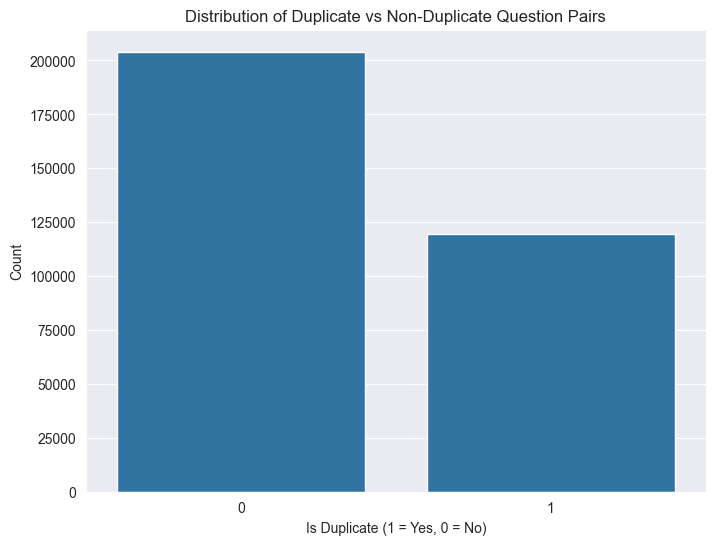

In [28]:
plt.figure(figsize=(8, 6))
sns.countplot(x='is_duplicate', data=train_df)
plt.title('Distribution of Duplicate vs Non-Duplicate Question Pairs')
plt.xlabel('Is Duplicate (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

In [29]:
proportions_df = (train_df.groupby(by='is_duplicate')[['question1_id']].count() / len(train_df)).rename(
    columns={'question1_id': 'proportion'}).reset_index()
prop_diff = proportions_df.loc[0, 'proportion'] - proportions_df.loc[1, 'proportion']
print(f"There is {prop_diff * 100:.2f}% non-duplicate question pairs ")

There is 26.16% non-duplicate question pairs 


The above plot shows that there are more non-duplicate pairs compared to duplicates ones.   
We could potentially leverage these via RL-based methods such as PPO or for our evaluator.

In [30]:
positive_pairs = train_df[train_df['is_duplicate'] == 1][['question1', 'question2']]
positive_pairs.columns = ['source', 'target']

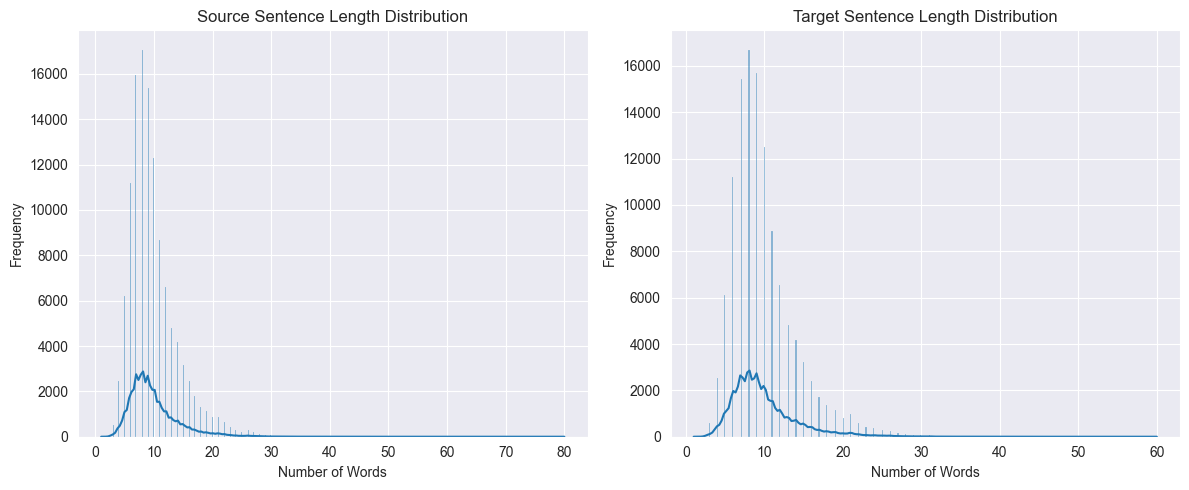

In [31]:
positive_pairs['source_len'] = positive_pairs['source'].apply(lambda x: len(x.split()))
positive_pairs['target_len'] = positive_pairs['target'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(positive_pairs['source_len'], kde=True)
plt.title('Source Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(positive_pairs['target_len'], kde=True)
plt.title('Target Sentence Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The above graph shows that the number of words in the sentences follows a gaussian distribution centered around ~8.
It also shows that for both questions, the distribution appears to be similar. 
This is reassuring as there is no imbalance disparity in the dataset.

In order to fine-tune our base model, I selected two automatic metrics which are relatively quick to compute:
- **Meteor aiming to evaluating semantic fidelity :**    
Unlike metrics that rely solely on exact word matches, METEOR incorporates stemming, synonymy, and paraphrase matching, providing a more nuanced assessment of semantic similarity.
    
- **N-gram Novelty (with N=3 here) to assessing lexical diversity :**     
- Originally introduced in [Evaluating n-Gram Novelty of Language Models Using Rusty-DAWG by Merrill et al. (2024)](https://aclanthology.org/2024.emnlp-main.800.pdf?utm_source=chatgpt.com), this metric measures the proportion of n-grams in the paraphrased text that are not present in the source sentence. By quantify how much new lexical content is introduced, it ensures that paraphrases are not replicas of the source but offer varied expressions.

In [32]:
train_df['ngram_novelty'] = train_df.progress_apply(
    lambda row: paraphrase_evaluator.calculate_ngram_novelty(row['question1'], row['question2'], n=3), axis=1
)
train_df['meteor'] = train_df.progress_apply(
    lambda row: paraphrase_evaluator.calculate_meteor(row['question1'], row['question2'])['meteor'], axis=1
)

100%|██████████| 323432/323432 [07:35<00:00, 709.58it/s]


try:
    train_df = pd.read_csv('train.csv')
except Exception as e:
    train_df.to_csv('train.csv', index=False)

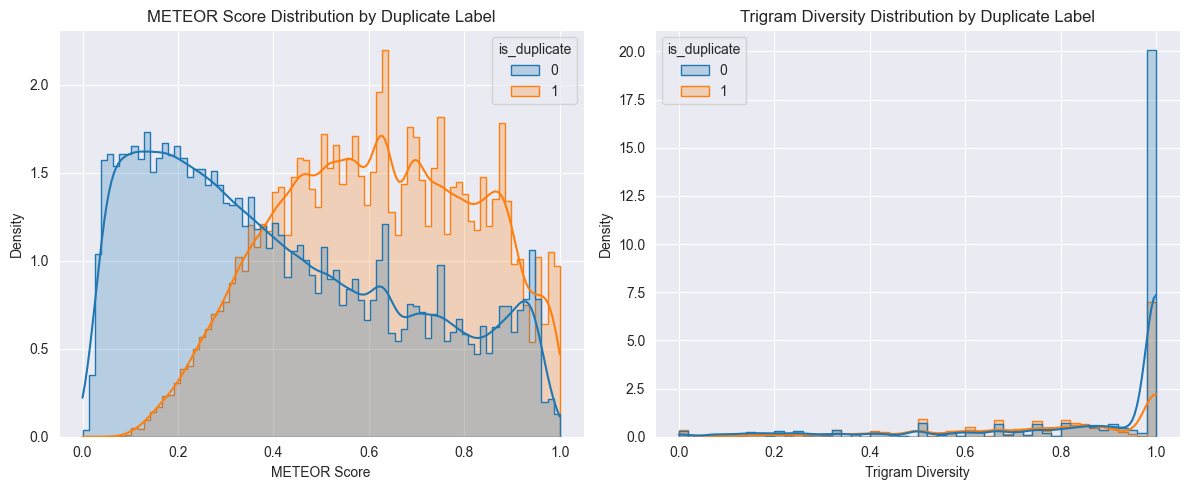

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Meteor Score Distribution
plt.subplot(1, 2, 1)
sns.histplot(data=train_df, x='meteor', hue='is_duplicate', kde=True, element="step", stat="density", common_norm=False)
plt.title('METEOR Score Distribution by Duplicate Label')
plt.xlabel('METEOR Score')
plt.ylabel('Density')

# 3-gram Diversity Distribution
plt.subplot(1, 2, 2)
sns.histplot(data=train_df, x='ngram_novelty', bins=50, hue='is_duplicate', kde=True, element="step", stat="density",
             common_norm=True)
plt.title('Trigram Diversity Distribution by Duplicate Label')
plt.xlabel('Trigram Diversity')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

Based on the above graph, we can see that the general trend on the training set is that a meteor score between 0.4 and 0.9 is most likely a proper paraphrase. Concerning the trigram diversity, it seems to appear quite uniform except at the very end, when diversity is above 0.9 and leaning towards 1 (i.e. no ressemblance between sentences).

Using this knowledge, we can now finetune our word net paraphraser according to it.

## Baseline Model: Thesaurus Based Approach


For the baseline model, I Built a **WordNet-based paraphraser** as a baseline due to its transparency, and historical relevance in paraphrase generation research. It is based on the word substitution baseline introduced by [Paraphrase Generation as Monolingual Translation: Data and Evaluation](https://aclanthology.org/W10-4223.pdf) (section 3.2). As a **thesaurus-based approach**, it performs targeted synonym substitution using WordNet, guided by part-of-speech tagging and lexical heuristics. Offering a clear and interpretable way to generate lexical variation without the complexity of neural models. While limited in semantic flexibility and syntactic diversity, it remains a strong low-resource baseline, particularly useful for highlighting the gains achieved by more advanced models.


https://aclanthology.org/2021.emnlp-main.414.pdf
https://aclanthology.org/2021.emnlp-main.414.pdf
https://aclanthology.org/2022.emnlp-main.208.pdf


In order to fine-tune the **WordNetParaphraser**'s hyperparameters,
we use a grid search approach and the previous metrics introduced, Meteor and n-gram novelty (with n=3)

replacement_probs: the probability of changing a POS word,    
min_tok_size: the minimal size of a token for it to be changed,   
max_synonyms: the maximal number of synonyms to choose from.




In [34]:
validation_source_sentences = valid_df[valid_df['is_duplicate'] == 1]['question1'].tolist()
validation_reference_sentences = valid_df[valid_df['is_duplicate'] == 1]['question2'].tolist()

In [35]:
replacement_probs = np.arange(0.5, 1, 0.1)
max_synonyms_list = np.arange(1, 3)
min_tok_sizes = np.arange(2, 5)

best_params = (-1, -1, -1)
best_score = -1
best_paraphrases = None

METEOR_SCORE_PROPORTION = 0.75
NGRAM_NOVELTY_PROPORTION = 0.25

OBSERVATION_MIN_METEOR = 0.4
OBSERVATION_MAX_METEOR = 0.9
OBSERVATION_NGRAM_NOVELTY = 0.9

In [36]:
set_seed(SEED)
for max_synonyms in max_synonyms_list:
    for min_tok_size in min_tok_sizes:
        for replacement_prob in tqdm(replacement_probs, desc="Testing synonym replacement"):
            wordnet_paraphraser = WordNetParaphraser(replacement_prob=replacement_prob,
                                                     max_synonyms=max_synonyms,
                                                     min_tok_size=min_tok_size)
            paraphrases = wordnet_paraphraser.batch_paraphrase(validation_source_sentences, verbose=False)
            batch_scores = paraphrase_evaluator.evaluate_batch(validation_source_sentences,
                                                               validation_reference_sentences,
                                                               paraphrases,
                                                               evaluated_metric=['meteor', 'ngram_novelty'],
                                                               verbose=False)
            meteor_score = batch_scores[1]['meteor']
            ngram_novelty_score = batch_scores[1]['ngram_novelty']
            current_score = meteor_score * METEOR_SCORE_PROPORTION + ngram_novelty_score * NGRAM_NOVELTY_PROPORTION
            if current_score > best_score and OBSERVATION_MIN_METEOR < meteor_score < OBSERVATION_MAX_METEOR and ngram_novelty_score < OBSERVATION_NGRAM_NOVELTY:
                best_params = (max_synonyms, min_tok_size, replacement_prob)
                best_score = current_score
                best_paraphrases = paraphrases


Testing synonym replacement: 100%|██████████| 7/7 [02:41<00:00, 23.06s/it]


In [38]:
displayed_num = 5
print(f"Best params: {best_params}")
print(f"Best score: {best_score}")

display_paraphrasing_results(validation_source_sentences, validation_reference_sentences, best_paraphrases,displayed_num)


Best params: (np.int64(1), np.int64(2), np.float64(0.9999999999999999))
Best score: 0.5413135971987386
Paraphrase: What be secularism ?
Source: What is secularism?
Reference: What is secularism? Are the Indian political parties secular?


Paraphrase: What will exist the wallop of the measure take to censor the 500 & 1000 Sri Lanka rupee short letter on Indian economic system ?
Source: What will be the impact of the step taken to ban the 500 & 1000 rupee note on Indian economy?
Reference: What will be the implications of banning 500 and 1000 rupees currency notes on Indian economy?


Paraphrase: How many gram of glucose ( C [ mathematics ] _6 [ /math ] H [ mathematics ] _12 [ /math ] O [ mathematics ] _6 [ /math ] ) be necessitate to do 250mL of an 0.360 answer ?
Source: How many grams of glucose (C[math]_6[/math]H[math]_12[/math]O[math]_6[/math]) are needed to make 250mL of an 0.360 solution?
Reference: How many grams of glucose (c6H12O6) are needed to make 250mL of an 0.360 solution?


In [39]:
replacement_prob = best_params[2]
max_synonyms = best_params[1]
min_tok_size = best_params[0]
wordnet_paraphraser = WordNetParaphraser(replacement_prob=replacement_prob,
                                         max_synonyms=max_synonyms,
                                         min_tok_size=min_tok_size)

### Evaluation of Baseline and boostrapping discussion

### Discussion

Evaluating paraphrasing quality is inherently challenging because a "good" paraphrase must balance multiple competing objectives:

**Semantic preservation:** The paraphrase must maintain the original meaning    
**Expression diversity:** It should differ lexically/syntactically from the original     
**Fluency and grammaticality:** It must be well-formed and natural-sounding     

This creates a fundamental tension, a perfect semantic match would be the original sentence itself (minimal diversity), while maximum diversity often compromises meaning preservation.

In the context of this evaluation, a collection of established metrics along with a reward model. are used to evaluate the performance of this model.

They include:
- Lexical Overlap Metrics:
    - BLEU: which measures n-gram overlap between candidate and reference, taking into account fluency but penalizes lexical diversity, and favors literal paraphrases.
    - Rouge: which measures overlap focusing on recall rather than precision, and evaluates textual coverage but penalizes lexical diversity.
    - METEOR: which incorporates stemming, synonymy and word alignment, more flexible than bleu and allows for synonym matching but is still to "superficial".
- Diversity Metrics:
    - Edit Distance: which measures transformation cost between sentences.
    - N-gram Novelty: which measures percentage of n-grams in paraphrase not in the original.
    - Jaccard Similarity: which measures word overlap using set operations.
- Similarity Metric:
    - A custom made, reward/evaluating model finetuned on the Quora dataset, incorporating MiniLM embeddings to capture the contextual intra and inter similarities for sentences. 

### Evaluation

In [43]:
test_source_sentences = test_df[test_df['is_duplicate'] == 1]['question1'].tolist()
test_reference_sentences = test_df[test_df['is_duplicate'] == 1]['question2'].tolist()

In [44]:
paraphrases = wordnet_paraphraser.batch_paraphrase(test_source_sentences, verbose=True)
batch_scores = paraphrase_evaluator.evaluate_batch(test_source_sentences,
                                                   test_reference_sentences,
                                                   paraphrases,
                                                   verbose=True)
print(batch_scores[1])

Evaluating: 100%|██████████| 14927/14927 [08:46<00:00, 28.35it/s]

{'bleu': np.float64(0.010054159707935963), 'meteor': np.float64(0.4126590467439272), 'rouge1': np.float64(0.33854759390835015), 'rouge2': np.float64(0.0760508290760806), 'rougeL': np.float64(0.3235287083987257), 'edit_distance': np.float64(0.5911284767269884), 'ngram_novelty': np.float64(0.8062506865607472)}


In [45]:
displayed_num = 5
display_paraphrasing_results(test_source_sentences, test_reference_sentences, paraphrases,displayed_num)

Paraphrase: How can I go arrant ?
Source: How can I become perfect?
Reference: How can I become perfect in everything?


Paraphrase: How perform I recover older snapchat message ?
Source: How do I retrieve old snapchat messages?
Reference: Is there any free tool to see my Boyfriend's Snapchat messages?


Paraphrase: What be the good online course for digital selling ?
Source: What are the best online courses for digital marketing?
Reference: What are the best online short courses in digital marketing?


Paraphrase: Exist Existence State of war 3 come up ?
Source: Is World War 3 coming?
Reference: Is there a war coming?


Paraphrase: Which fancied fictitious character perform you consider you exist and why ?
Source: Which fictional character do you think you are and why?
Reference: Which fictional character are you?




In [51]:
from models.reward_model import RewardModel
from trainers.reward_trainer import test_reward_model

reward_batch_size = 128
reward_num_epochs = 3
reward_learning_rate = 1e-4
reward_print_every = 100

reward_model = RewardModel()
reward_model.eval()
reward_model.load_state_dict(torch.load('storage/reward_model.pt'))

test_dataset = QuoraDataset(quora_dataset['test'])
test_dataloader = DataLoader(test_dataset,
                              batch_size=reward_batch_size,
                              shuffle=True,
                              drop_last=False)

accuracy = test_reward_model(reward_model, test_dataloader)
batch_scores[1]['reward_accuracy'] = accuracy
print(f"Evaluator/Reward Model Accuracy: {accuracy}")


100%|██████████| 316/316 [01:06<00:00,  4.76it/s]

Evaluator/Reward Model Accuracy: 0.7938855771846941


In [ ]:
valid_df[valid_df['is_duplicate'] == 1].iloc[5]

In [70]:
model_name = "paraphrase_model_output/checkpoint-471"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [71]:
PROMPT = "Paraphrase the following sentence: {source} ### Paraphrase:"


In [72]:
formated_ds = [PROMPT.format(source=sentence) for sentence in test_dataset[:10][0]]

In [76]:
model.eval()
with torch.no_grad():
    query_tensors = tokenizer(formated_ds, return_tensors="pt", padding=True, padding_side='left')
    output = model.generate(query_tensors.input_ids,attention_mask=query_tensors.attention_mask, top_p=0.9, max_new_tokens=50, temperature=0.1, top_k=0,
                            repetition_penalty=1.2, early_stopping=True, do_sample=True)
    predictions = tokenizer.batch_decode(output, skip_special_tokens=True)
    preds = predictions


/opt/homebrew/anaconda3/envs/paraenv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:679: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [77]:
preds

['Paraphrase the following sentence: How can I become perfect? ### Paraphrase: The best way to be a good person is by being honest. ## Paraphrasing, paraphrases and rephrasings are all used in writing when you want your reader or listener to understand what you mean without having to read it yourself (or',
 'Paraphrase the following sentence: What does the laws in Honduras regarding Razor Edge Pitbulls say? ### Paraphrase: The Laws of Honduras Regarding Razor Edge Pitbull. (1) This is a very important law that has been passed by the Honduran government to protect these dogs from being shot or killed for their fur and skin, which are considered illegal under the',
 'Paraphrase the following sentence: What is the best way to type Spanish accents in Windows 7? ### Paraphrase: The best way to type Spanish accents in Windows 7. This means that you can use a keyboard shortcut or an accent key on your computer, and then write out each word with its correct pronunciation using the appropriate 